<a href="https://colab.research.google.com/gist/jonghank/47ef6db69f13d9a52281671e2c107eca/trend_filtering_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trend filtering


$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$



__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

We are given a scalar time series $y_t$, $t = 1,\dots,n$, assumed to consist of an underlying slowly varying trend $x_t$ and a more rapidly varying random component $z_t$. Our goal is to estimate the trend component $x_t$ or, equivalently, estimate the random component $z_t = y_t - x_t$. This can be considered as an optimization problem with two competing objectives: We want $x_t$ to be smooth, and we want $z_t$ (our estimate of the random component, sometimes called the residual) to be small. In some contexts, estimating $x_t$ is called _smoothing_ or _filtering_.


<br>

For example, Samsung Electronics stock prices over the past 10 years are loaded below.


In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
import datetime as dt 

end = dt.datetime.today()
start = dt.datetime(end.year-10, end.month, end.day)

df = yf.download('005930.KS', start, end)

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-03-25,29600.0,29900.0,29400.0,29900.0,23896.960938,10272050
2013-03-26,29900.0,30440.0,29820.0,30180.0,24120.740234,16830000
2013-03-27,30300.0,30320.0,29740.0,30080.0,24040.824219,12881400
2013-03-28,30060.0,30200.0,29940.0,30200.0,24136.728516,7989600
2013-03-29,30480.0,30640.0,30340.0,30540.0,24408.464844,9533700
...,...,...,...,...,...,...
2023-03-16,59200.0,60200.0,59100.0,59900.0,59900.000000,10611939
2023-03-17,60800.0,61300.0,60600.0,61300.0,61300.000000,14090110
2023-03-20,61100.0,61200.0,60200.0,60200.0,60200.000000,9618009


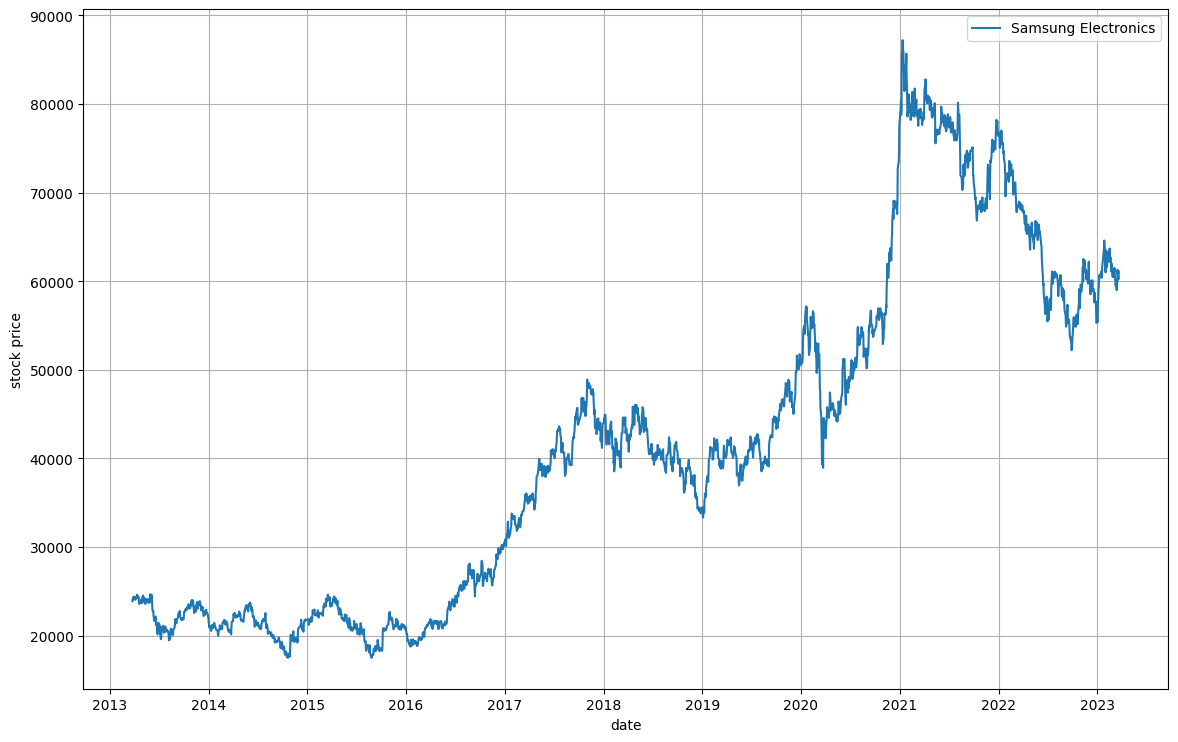

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14,9), dpi=100)
plt.plot(df['Adj Close'], label='Samsung Electronics')
plt.xlabel('date')
plt.ylabel('stock price')
plt.grid()
plt.legend()
plt.show()

<br>

We will take the _Close price (adjusted)_ from which we will try to read the trend, and will normalize the data. The plot follows below. Can you read the trend from it? 

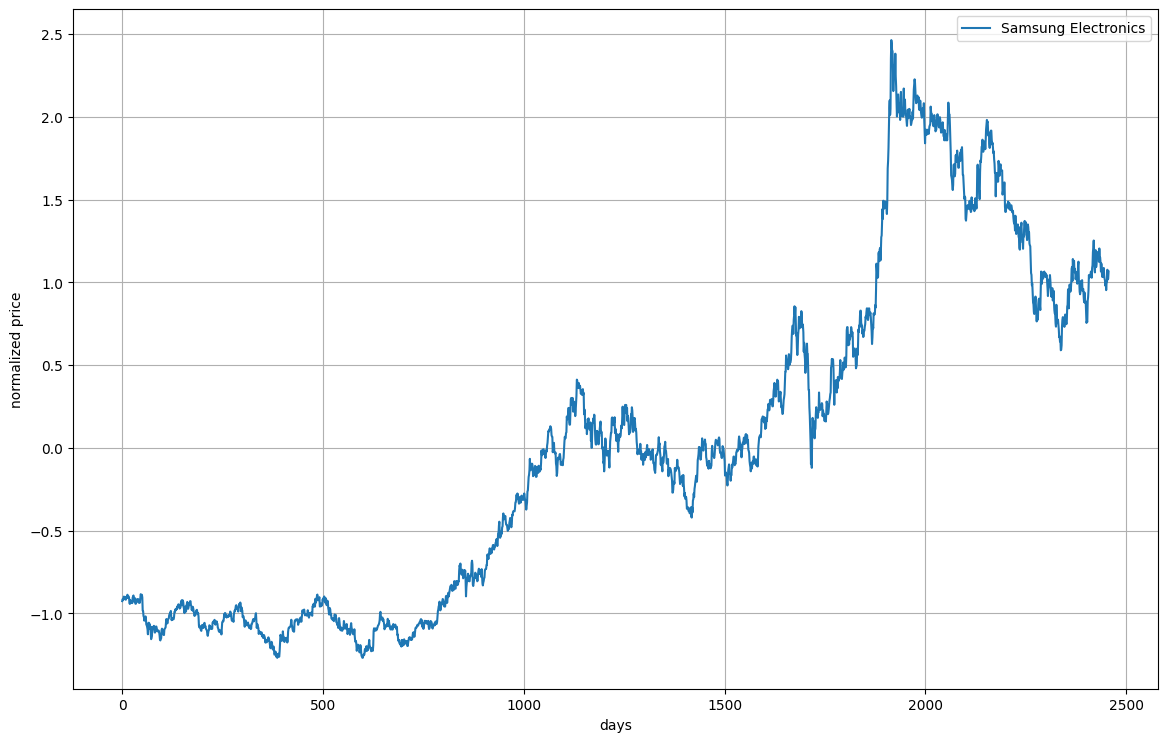

In [4]:
import numpy as np
import matplotlib.pyplot as plt

y = df['Adj Close'].values
y -= np.mean(y)
y /= np.std(y)

n = len(y)

plt.figure(figsize=(14,9), dpi=100)
plt.plot(y, label='Samsung Electronics')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.grid()
plt.legend()
plt.show()

<br>

Reading the trend out from given time-series data can be formulated by following. The underlying trend $x_t$ should explain the observed data $y_t$, at the same time, we expect the trend (inclination) wouldn't change frequently, so we would like to find $x_1,\dots,x_n$ such that

- $x_t-y_t$ is small for $t=1,\dots,n$
- $\left(x_{t+2}-x_{t+1}\right)-\left(x_{t+1}-x_{t}\right)$ is small for $t=1,\dots,n-2$

for which we formulate the optimization problem by

$$
\begin{aligned}
  \underset{x_1,\dots,x_n}{\minimize} \quad & \sum_{t=1}^{n}\left(y_t-x_t\right)^2  
  + \lambda\sum_{t=1}^{n-2}\left(x_{t+2}-2x_{t+1}+x_t\right)^2
\end{aligned}
$$

with some positive $\lambda$. This is equivalent to 

$$
\begin{aligned}
  \underset{x}{\minimize} \quad & \|x-y\|_2^2 + \lambda\|Dx\|_2^2
\end{aligned}
$$

where $x = (x_1, \dots, x_n)$, $y = (y_1, \dots, y_n )$, with

$$
\begin{aligned}
D &= \bmat{
1 & -2 & 1 & & \\
& \ddots & \ddots & \ddots & \\
& &  1 & -2 & 1 \\
}
\end{aligned}
$$

This is again equivalent to

$$
\begin{aligned}
  \underset{x}{\minimize} \quad & \left\|\bmat{I \\ \sqrt{\lambda}D}x-\bmat{y\\0}\right\|_2^2
\end{aligned}
$$
whose optimal solution $x^*$ is given by

$$
   x^*=\bmat{I \\ \sqrt{\lambda}D}^\dagger \bmat{y\\0}
 $$
 
or
$$
   x^*=\left(I+\lambda D^TD\right)^{-1}y
$$


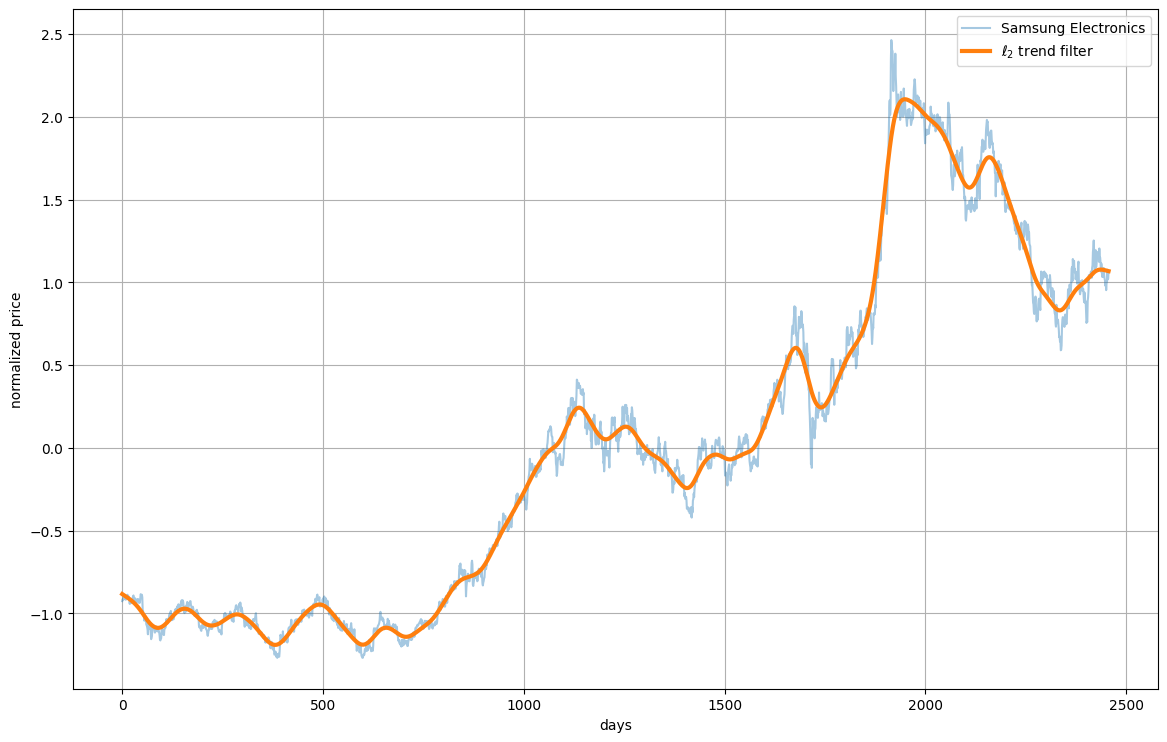

In [5]:
lam = 1e5

A = np.eye(n)

D = np.zeros((n-2,n))
for i in range(D.shape[0]):
  D[i,i:i+3] = [1, -2, 1]

A_tilde = np.vstack((A,np.sqrt(lam)*D))
y_tilde = np.hstack((y,np.zeros(n-2)))

xhat = np.linalg.lstsq(A_tilde,y_tilde,rcond=None)[0]

plt.figure(figsize=(14,9), dpi=100)
plt.plot(y, alpha=0.4, label='Samsung Electronics')
plt.plot(xhat,linewidth=3, label=r'$\ell_2$ trend filter')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.grid()
plt.legend()
plt.show()

<br>

The code below is equal to the above, but the below computes the optimal solution way faster than the above, since it facilitates the sparsity of $D$.

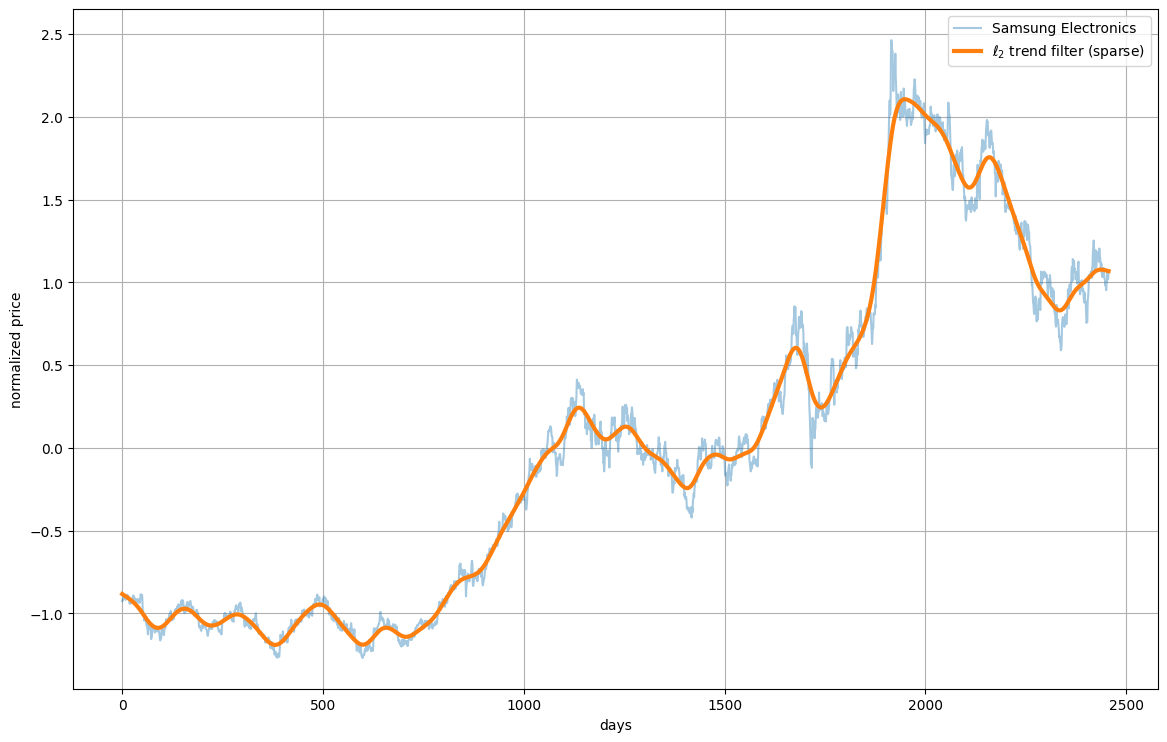

In [6]:
import scipy.sparse as ssp
import scipy.sparse.linalg as sla

lam = 1e5

As = ssp.eye(n)

Ds = ssp.spdiags([np.ones(n), -2*np.ones(n), np.ones(n)], [0, 1, 2], n-2, n)

As_tilde = ssp.vstack((As, np.sqrt(lam)*Ds))
y_tilde = np.hstack((y, np.zeros(n-2)))

xhats = sla.lsqr(As_tilde,y_tilde)[0]

plt.figure(figsize=(14,9), dpi=100)
plt.plot(y, alpha=0.4, label='Samsung Electronics')
plt.plot(xhats,linewidth=3, label=r'$\ell_2$ trend filter (sparse)')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.grid()
plt.legend()
plt.show()

<br>

Looks like the below finds something that better explains the underlying trend with intuitive line segments, though the solution is not obtained from the least squares sense. In fact the below defines the problem just by replacing the $\ell_2$ norm with the $\ell_1$ norm as follows:

$$
\begin{aligned}
  \underset{x_1,\dots,x_n}{\minimize} \quad & \sum_{t=1}^{n}| y_t-x_t |  
  + \lambda\sum_{t=1}^{n-2} | x_{t+2}-2x_{t+1}+x_t|
\end{aligned}
$$

which is equivalent to solving:

$$
\begin{aligned}
  \underset{x}{\minimize} \quad & \|x-y\|_1 + \lambda\|Dx\|_1
\end{aligned}
$$

We haven't discussed how we could solve this, but we will soon come back to this at some point in this class.

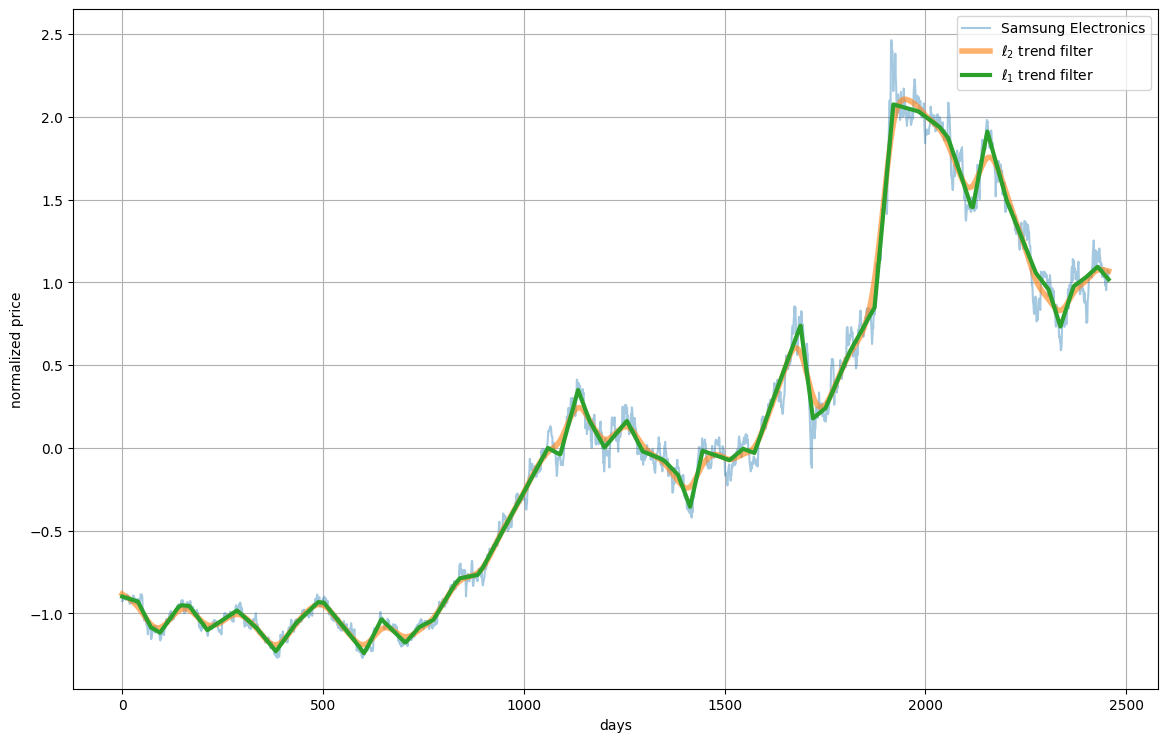

In [7]:
import cvxpy as cp

x = cp.Variable(n)
obj = cp.Minimize( cp.norm(y-As@x,1) + 100*cp.norm(Ds@x,1) )
prob = cp.Problem(obj)
prob.solve(solver=cp.ECOS, verbose=False, max_iters=100)

plt.figure(figsize=(14,9), dpi=100)
plt.plot(y, alpha=0.4, label='Samsung Electronics')
plt.plot(xhats,linewidth=4, alpha=0.6, label=r'$\ell_2$ trend filter')
plt.plot(x.value,linewidth=3, label=r'$\ell_1$ trend filter')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.grid()
plt.legend()
plt.show()

<br>

Now, what if your data is partially corrupted? Let us add some large non-Gaussian intermittent noise to your data.

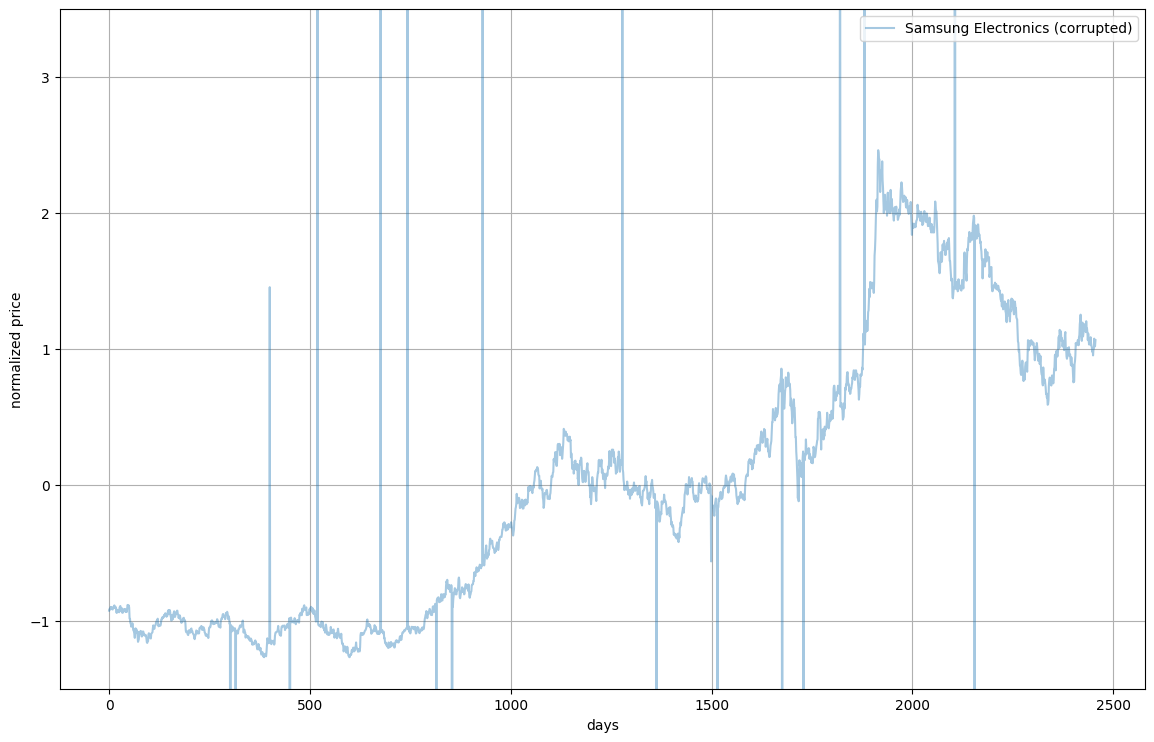

In [8]:
z = 10*np.random.randn(n)

for i in range(n):
  if np.random.rand() > 0.01:
    z[i] = 0
    
y_cor = y + z

plt.figure(figsize=(14,9), dpi=100)
plt.plot(y_cor, alpha=0.4, label='Samsung Electronics (corrupted)')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.ylim(-1.5,3.5)
plt.grid()
plt.legend()
plt.show()

<br>

We notice that the $\ell_2$ trend filter responds (very sensitively) to this type of noise as follows.

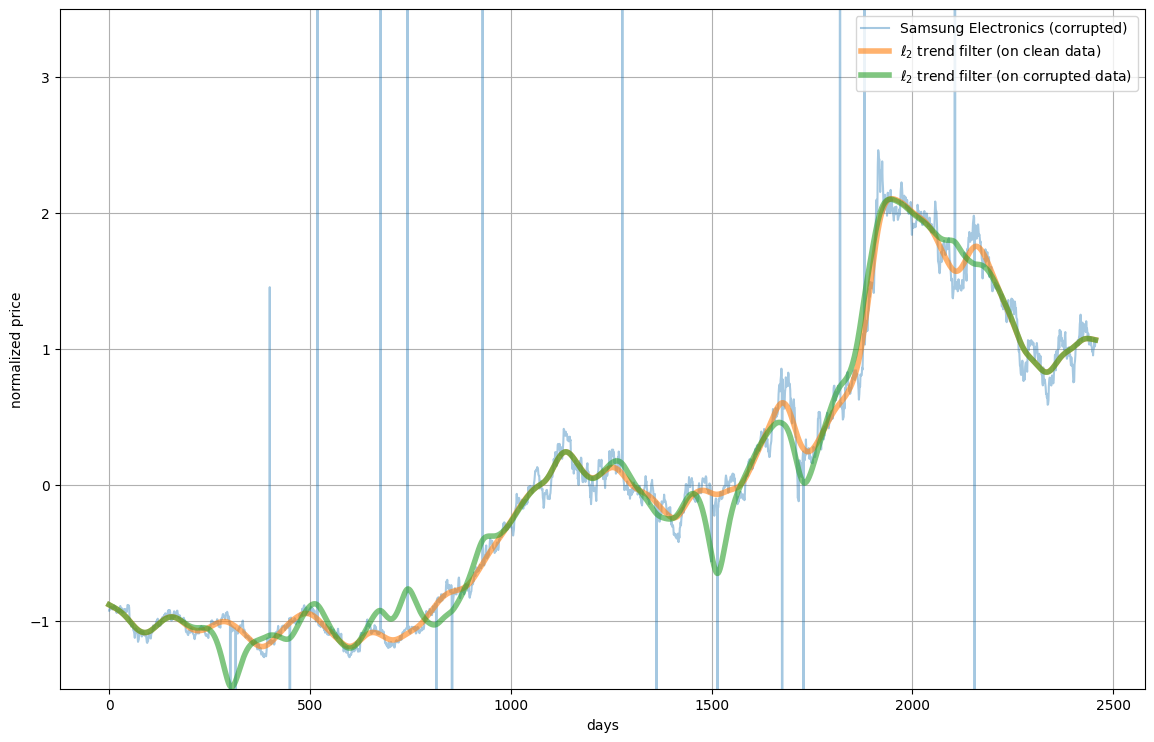

In [9]:
b_tilde_cor = np.hstack((y_cor, np.zeros(n-2)))
xhats_cor = sla.lsqr(As_tilde,b_tilde_cor)[0]

plt.figure(figsize=(14,9), dpi=100)
plt.plot(y_cor, alpha=0.4, label='Samsung Electronics (corrupted)')
plt.plot(xhats,linewidth=4, alpha=0.6, label=r'$\ell_2$ trend filter (on clean data)')
plt.plot(xhats_cor,linewidth=4, alpha=0.6, label=r'$\ell_2$ trend filter (on corrupted data)')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.ylim(-1.5,3.5)
plt.grid()
plt.legend()
plt.show()

<br>

What about the $\ell_1$ trend filter?

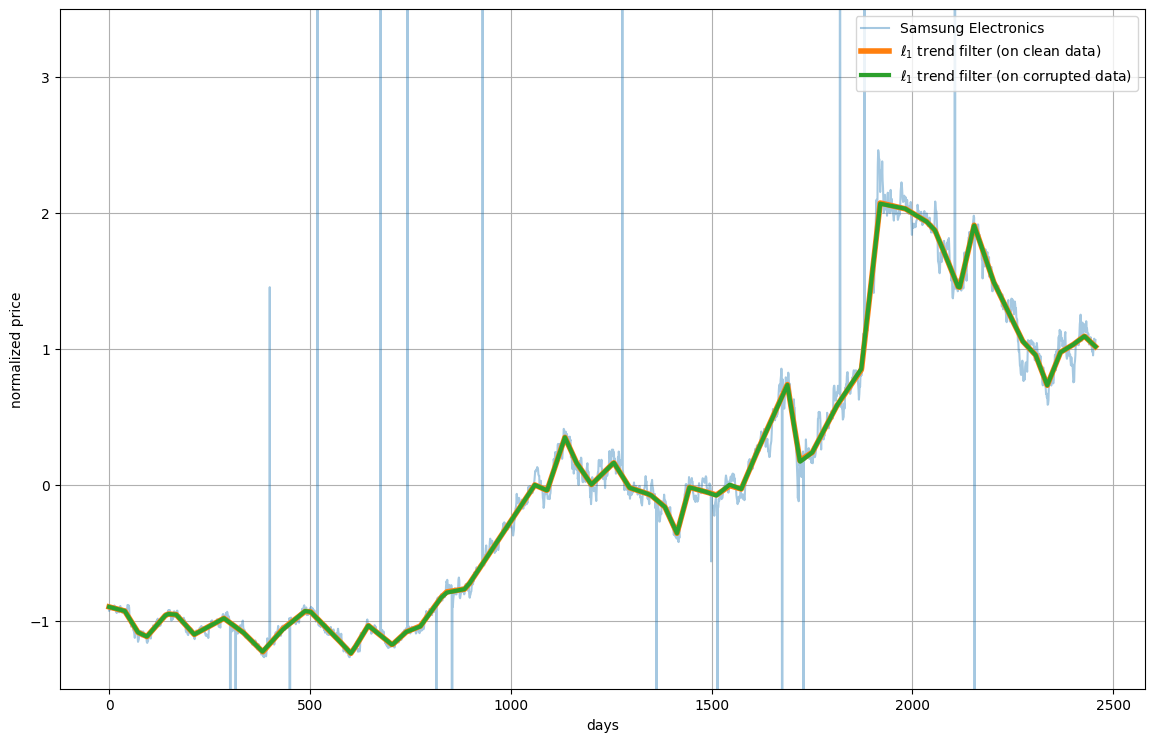

In [10]:
x_cor = cp.Variable(n)
obj = cp.Minimize( cp.norm(y_cor-As@x_cor,1) + 100*cp.norm(Ds@x_cor,1) )
prob = cp.Problem(obj)
prob.solve(solver=cp.ECOS, verbose=False, max_iters=100)

plt.figure(figsize=(14,9), dpi=100)
plt.plot(y_cor, alpha=0.4, label='Samsung Electronics')
plt.plot(x.value, linewidth=4, label=r'$\ell_1$ trend filter (on clean data)')
plt.plot(x_cor.value, linewidth=3, label=r'$\ell_1$ trend filter (on corrupted data)')
plt.xlabel('days')
plt.ylabel('normalized price')
plt.ylim(-1.5,3.5)
plt.grid()
plt.legend()
plt.show()